# Model Tracking and Versioning

## Introduction

***VerticaPy*** is an open-source Python package on top of Vertica database that supports pandas-like virtual dataframes over database relations. VerticaPy provides scikit-type machine learning functionality on these virtual dataframes. Data is not moved out of the database while performing machine learning or statistical analysis on virtual dataframes. Instead, the computations are done at scale in a distributed fashion inside the Vertica cluster. VerticaPy also takes advantage of multiple Python libraries to create a variety of charts, providing a quick and easy method to illustrate your statistical data.

In this article, we will introduce two new ***MLOps*** tools recently added to VerticaPy: *Model Tracking* and *Model Versioning*. For comprehensive documentation of all VerticaPy functionality, visit https://www.vertica.com/python.

## Model Tracking

Data scientists usually train many ML models for a project. To help choose the best model, data scientists need a way to keep track of all candidate models and compare them using various metrics. VerticaPy provides a model tracking system to facilitate this process for a given experiment. The data scientist first creates an experiment object and then adds candidate models to that experiment. The information related to each experiment can be automatically backed up in the database, so if the Python environment is closed for any reason, like a holiday, the data scientist has peace of mind that the experiment can be easily retrieved. The experiment object also provides methods to easily compare the prediction performance of its associated models and to pick the model with the best performance on a specific test dataset.

The following example demonstrates how the model tracking feature can be used for an experiment that trains a few binary-classifier models on the Titanic dataset. First, we must load the titanic data into our database and store it as a virtual dataframe (vDF):

In [40]:
from verticapy.datasets import load_titanic

titanic_vDF = load_titanic()
predictors = ["age", "fare", "pclass"]
response = "survived"

We then define a vExperiment object to track the candidate models. To define the experiment object, specify the following parameters:

- experiment_name: The name of the experiment.
- test_relation: Relation or vDF to use to test the model.
- X: List of the predictors.
- y: Response column.

***Note:*** If experiments_type is set to clustering, test_relation, X, and Y must be set to None.

The following parameters are optional:

- experiment_type: By default 'auto', meaning VerticaPy tries to detect the experiment type from the response value. However, it might be cleaner to explicitly specify the experiment type. The other valid values for this parameter are 'regressor' (for regression models), 'binary' (for binary classification models), 'multi' (for multiclass classification models), and 'clustering' (for clustering models).
- experiment_table: The name of the table ([schema_name.]table_name) in the database to archive the experiment. The experiment information won't be backed up in the database without specifying this parameter. If the table already exists, its previously stored experiments are loaded to the object. In this case, the user must have SELECT, INSERT, and DELETE privileges on the table. If the table doesn't exist and the user has the necessary privileges for creating such a table, the table is created.

In [41]:
import verticapy.mlops.model_tracking as mt

my_experiment_1 = mt.vExperiment(experiment_name = "my_exp_1",
                              test_relation = titanic_vDF,
                              X=predictors,
                              y=response,
                              experiment_type="binary",
                              experiment_table="my_exp_table_1")

After creating the experiment object, we can train different models and add them to the experiment:

In [42]:
# training a LogisticRegression model
from verticapy.learn.linear_model import LogisticRegression
model_1 = LogisticRegression("logistic_reg_m", overwrite_model=True)
model_1.fit(titanic_vDF, predictors, response)
my_experiment_1.add_model(model_1)

# training a LinearSVC model
from verticapy.learn.svm import LinearSVC
model_2 = LinearSVC("svc_m", overwrite_model=True)
model_2.fit(titanic_vDF, predictors, response)
my_experiment_1.add_model(model_2)

# training a DecisionTreeClassifier model
from verticapy.learn.tree import DecisionTreeClassifier
model_3 = DecisionTreeClassifier("tree_m", overwrite_model=True, max_depth=3)
model_3.fit(titanic_vDF, predictors, response)
my_experiment_1.add_model(model_3)

So far we have only added three models to the experiment, but we could add many more in a real scenario. Using the experiment object, we can easily list the models in the experiment and pick the one with the best prediction performance based on a specified metric.

,model_name,model_type,,auc,prc_auc,accuracy,log_loss,precision,recall,f1_score,mcc,informedness,markedness,csi,user_defined_metrics
1,logistic_reg_m,LogisticRegression,,0.7260510240747399,0.6425502893997783,0.6957831325301205,0.255281396006693,0.658273381294964,0.4680306905370844,0.547085201793722,nan,0.3110058971486547,0.36857978798020086,0.3765432098765432,[null]
2,svc_m,LinearSVC,,0.7262327999830908,0.6422018358059188,0.6997991967871486,0.268972113802438,0.6678832116788321,0.4680306905370844,0.5503759398496241,nan,0.3176174673965886,0.37979456901955233,0.3796680497925311,[null]
3,tree_m,RandomForestClassifier,,0.7211726659761998,0.6890311481722489,0.7068273092369478,0.251082469122067,0.7239819004524887,0.4092071611253197,0.522875816993464,1.6908954624726606,0.30838071484432805,0.42591738432345627,0.35398230088495575,[null]

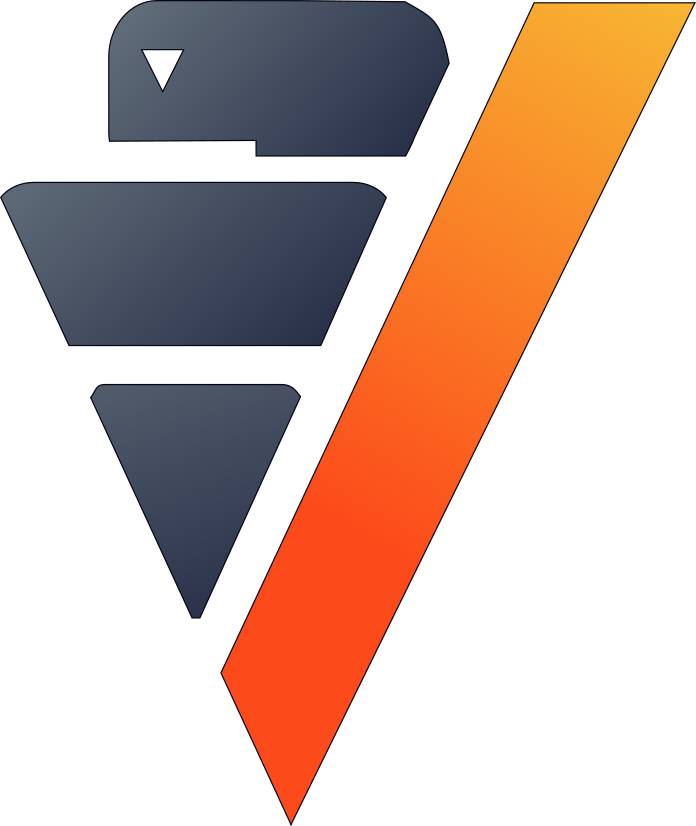

In [43]:
my_experiment_1.list_models()

In [44]:
top_model = my_experiment_1.load_best_model(metric="auc")

The experiment object facilitates not only model tracking but also makes cleanup super easy, especially in real-world scenarios where there is often a large number of leftover models. The 'drop' method drops from the database the info of the experiment and all associated models other than those specified in the *keeping_models* list.

In [45]:
my_experiment_1.drop(keeping_models=[top_model.model_name])

Experiments are also helpful for performing grid search on hyper-parameters. The following example shows how they can be used to study the impact of the max_iter parameter on the prediction performance of LogisticRegression models.

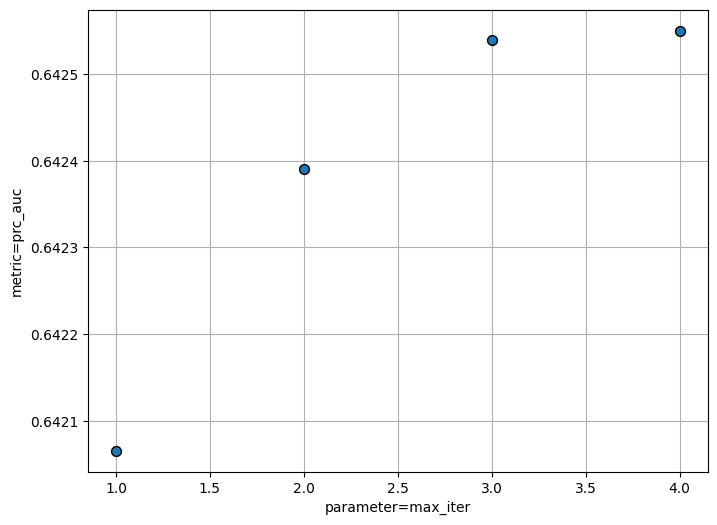

In [46]:
# creating an experiment
my_experiment_2 = mt.vExperiment(experiment_name = "my_exp_2",
                              test_relation = titanic_vDF,
                              X=predictors,
                              y=response,
                              experiment_type="binary")

# training LogisticRegression with different values of max_iter
for i in range(1, 5):
    model = LogisticRegression(max_iter=i)
    model.fit(titanic_vDF, predictors, response)
    my_experiment_2.add_model(model)
    
# plotting prc_auc vs max_iter
my_experiment_2.plot("max_iter", "prc_auc")

# cleaning all the models associated to the experimen from the database
my_experiment_2.drop()

## Model Versioning

In Vertica version 12.0.4, we added support for [In-DB ML Model Versioning](https://docs.vertica.com/23.3.x/en/data-analysis/ml-predictive-analytics/model-management/model-versioning/). Now, we have integrated it into VerticaPy so that users can utilize its capabilities along with the other tools in VerticaPy. In VerticaPy, model versioning is a wrapper around an SQL API already built in Vertica. For more information about the concepts of model versioning in Vertica, see the Vertica documentation.

To showcase model versioning, we will begin by registering the `top_model` picked from the above experiment.

In [47]:
top_model.register("top_model_demo")

True

When the model owner registers the model, its ownership changes to DBADMIN, and the previous owner receives USAGE privileges. Registered models are referred to by their registered_name and version. Only DBADMIN or a user with the MLSUPERVISOR role can change the status of a registered model. We have provided the RegisteredModel class in VerticaPy for working with registered models.

We will now make a RegisteredModel object for our recently registered model and change its status to "production". We can then use the registered model for scoring.

In [48]:
import verticapy.mlops.model_versioning as mv

rm = mv.RegisteredModel("top_model_demo")

To see the list of all models registered as "top_model_demo", use the list_models() method.

,Abcregistered_nameVarchar(128),123registered_versionInteger,AbcstatusVarchar(128),📅registered_timeTimestamptz(35),123model_idInteger,Abcschema_nameVarchar(128),Abcmodel_nameVarchar(128),Abcmodel_typeVarchar(128),AbccategoryVarchar(128)
1,top_model_demo,3,UNDER_REVIEW,2023-10-19 15:56:21.141198-04:00,45035996273853304,public,svc_m,SVM_CLASSIFIER,VERTICA_MODELS

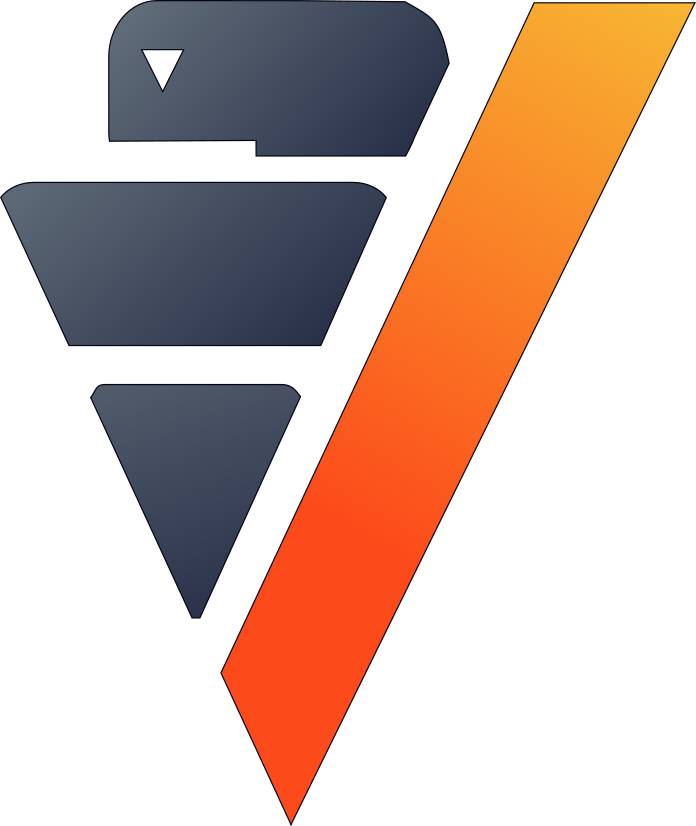

In [49]:
rm.list_models()

The model we just registered has a status of "under_review". The next step is to change the status of the model to "staging", which is meant for A/B testing the model. Assuming the model performs well, we will promote it to the "production" status. Please note that we should specify the right version of the registered model from the above table.

In [51]:
# changing the status of the model to staging
rm.change_status(version=3, new_status="staging")

# changing the status of the model to production
rm.change_status(version=3, new_status="production")

There can only be one version of the registered model in "production" at any time. The following predict function applies to the model with "production" status by default. If you want to run the predict function on a model with a status other than "production", you must also specify the model version.

,123pclassInteger,123survivedInteger,AbcVarchar(164),AbcsexVarchar(20),123ageNumeric(8),123sibspInteger,123parchInteger,AbcticketVarchar(36),123fareNumeric(12),AbccabinVarchar(30),AbcembarkedVarchar(20),AbcboatVarchar(100),123bodyInteger,AbcVarchar(100),123predicted_valueInteger
1,1,0,,male,30.0,1,2,113781,151.55,C22 C26,S,[null],135,,1
2,1,0,,male,45.0,0,0,113784,35.5,T,S,[null],[null],,1
3,1,0,,male,[null],0,0,113798,31.0,[null],S,[null],[null],,[null]
4,1,0,,male,28.0,0,0,113059,47.1,[null],S,[null],[null],,1
5,1,0,,male,50.0,1,0,PC 17761,106.425,C86,C,[null],62,,1
6,1,0,,female,36.0,0,0,PC 17531,31.6792,A29,C,[null],[null],,1
7,1,0,,male,30.0,0,0,113051,27.75,C111,C,[null],[null],,1
8,1,0,,male,46.0,0,0,PC 17593,79.2,B82 B84,C,[null],[null],,1
9,1,0,,male,40.0,0,0,112059,0.0,B94,S,[null],110,,1
10,1,0,,male,[null],0,0,17463,51.8625,E46,S,[null],[null],,[null]

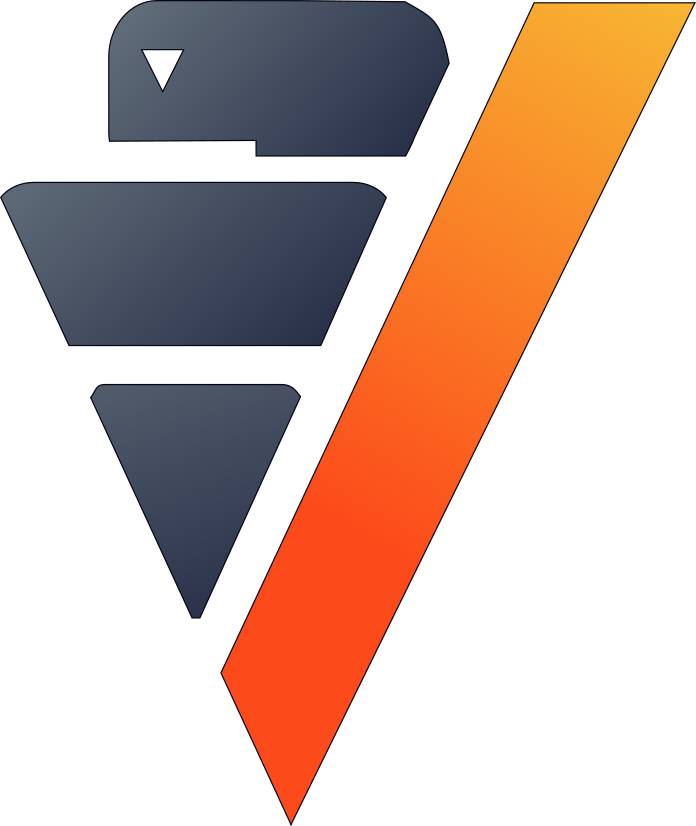

In [52]:
rm.predict(titanic_vDF, X=predictors, name="predicted_value")

DBADMIN and users who are granted SELECT privileges on the v_monitor.model_status_history table are able to monitor the status history of registered models.

,Abcregistered_nameVarchar(128),123registered_versionInteger,Abcnew_statusVarchar(128),Abcold_statusVarchar(128),📅status_change_timeTimestamptz(35),123operator_idInteger,Abcoperator_nameVarchar(128),123model_idInteger,Abcschema_nameVarchar(128),Abcmodel_nameVarchar(128)
1,top_model_demo,3,UNDER_REVIEW,UNREGISTERED,2023-10-19 15:56:21.150875-04:00,45035996273704962,afard,45035996273853304,public,svc_m
2,top_model_demo,3,STAGING,UNDER_REVIEW,2023-10-19 15:56:38.961325-04:00,45035996273704962,afard,45035996273853304,public,svc_m
3,top_model_demo,3,PRODUCTION,STAGING,2023-10-19 15:56:39.088134-04:00,45035996273704962,afard,45035996273853304,public,svc_m
4,top_model_demo,1,UNDER_REVIEW,UNREGISTERED,2023-10-19 15:46:38.893000-04:00,45035996273704962,afard,45035996273851606,[null],[null]
5,top_model_demo,1,STAGING,UNDER_REVIEW,2023-10-19 15:47:31.840529-04:00,45035996273704962,afard,45035996273851606,[null],[null]
6,top_model_demo,1,PRODUCTION,STAGING,2023-10-19 15:47:31.960033-04:00,45035996273704962,afard,45035996273851606,[null],[null]
7,top_model_demo,2,UNDER_REVIEW,UNREGISTERED,2023-10-19 15:53:28.648945-04:00,45035996273704962,afard,45035996273852750,[null],[null]
8,top_model_demo,2,STAGING,UNDER_REVIEW,2023-10-19 15:54:02.120317-04:00,45035996273704962,afard,45035996273852750,[null],[null]
9,top_model_demo,2,PRODUCTION,STAGING,2023-10-19 15:54:02.238576-04:00,45035996273704962,afard,45035996273852750,[null],[null]

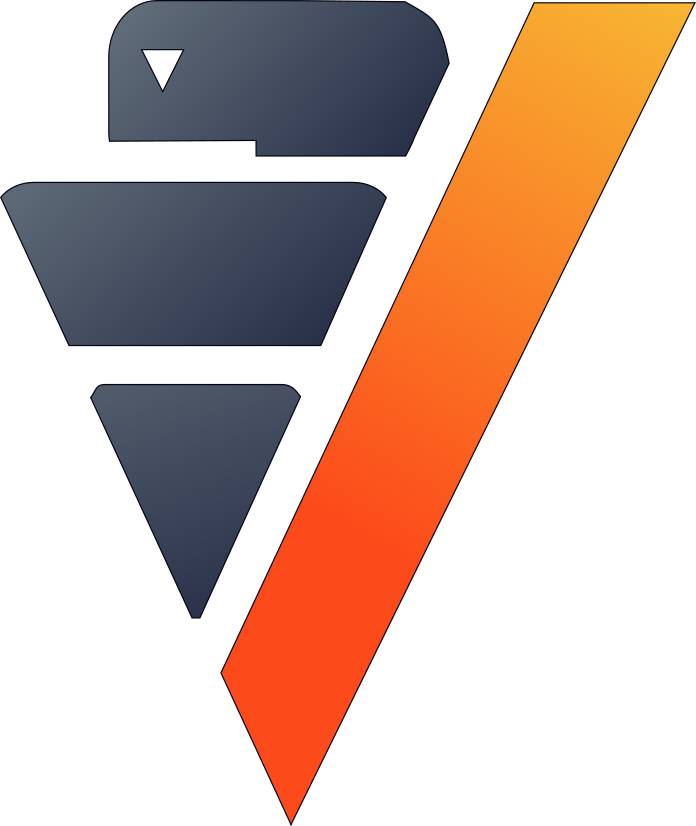

In [53]:
rm.list_status_history()

# Conclusion

The addition of model tracking and model versioning to the VerticaPy toolkit greatly improves VerticaPy's MLOps capabilities. We are constantly working to improve VerticaPy and address the needs of data scientists who wish to harness the power of Vertica database to empower their data analyses. If you have any comments or questions, don't hesitate to reach out in the [VerticaPy github community](https://github.com/vertica/VerticaPy/discussions).